# Model 1B — Regression Baseline (Torque Forecasting)

This notebook is an **optional baseline** included to contrast regression vs. classification for the project.

Goal (regression):
- Predict the **next-step torque** value (`Torque_future`) using an ordered sequence derived from `Tool wear [min]`.

_(Predict mean torque at tool_wear = t+1 using features at tool_wear = t)_

Important note:
- This regression task is *not* the primary predictive maintenance objective (failure prediction).
- It is included to demonstrate why **direct failure classification** is more actionable for maintenance decisions.


### 1. Setup

In [7]:
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 120)

### 2. Load data

We load the prepared dataset if available. Otherwise, we load the raw dataset and apply minimal preprocessing (drop identifiers and one-hot encode `Type`).

For regression, the failure-mode flags are not used.

In [8]:
DATA_PREPARED_PATH = "../data/ai4i_prepared.csv"
DATA_RAW_PATH = "../data/ai4i_2020_predictive_maintenance.csv"

TIME_COL = "Tool wear [min]"

def load_dataset():
    if os.path.exists(DATA_PREPARED_PATH):
        df = pd.read_csv(DATA_PREPARED_PATH)
        source = "prepared"
    else:
        df_raw = pd.read_csv(DATA_RAW_PATH)

        # Minimal preprocessing
        drop_cols = ["UDI", "Product ID"]
        df = df_raw.drop(columns=[c for c in drop_cols if c in df_raw.columns], errors="ignore")

        if "Type" in df.columns:
            df = pd.get_dummies(df, columns=["Type"], drop_first=True)

        source = "raw+prepped"
    return df, source

df, source = load_dataset()
print(f"Loaded source: {source}")
print("Shape:", df.shape)
df.head()

Loaded source: prepared
Shape: (10000, 14)


,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,7257,H36670,H,300.2,310.3,1408,42.5,0,0,0,0,0,0,0
2,504,M15363,M,297.6,309.2,1442,48.1,0,0,0,0,0,0,0
3,7169,L54348,L,300.3,310.3,1704,29.5,0,0,0,0,0,0,0
4,7089,M21948,M,300.6,310.3,1614,32.7,0,0,0,0,0,0,0


### 3. Create an ordered sequence using tool wear (time proxy)

We aggregate sensor readings by `Tool wear [min]` to form a monotonic sequence.
Then we define `Torque_future` as the next step torque value (one-step-ahead forecasting).

In [9]:
required_cols = [
    "Air temperature [K]",
    "Process temperature [K]",
    "Rotational speed [rpm]",
    "Torque [Nm]",
    TIME_COL,
]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}")

# Aggregate by tool wear (population-level) to build an ordered sequence
df_tw = (
    df
    .groupby(TIME_COL, as_index=False)
    .mean(numeric_only=True)
    .sort_values(TIME_COL)
    .reset_index(drop=True)
)

# One-step-ahead target
df_tw["Torque_future"] = df_tw["Torque [Nm]"].shift(-1)
df_tw = df_tw.dropna().reset_index(drop=True)

print("Aggregated shape:", df_tw.shape)
df_tw.head()

Aggregated shape: (245, 13)


,Tool wear [min],UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Machine failure,TWF,HDF,PWF,OSF,RNF,Torque_future
0,0,5014.266667,299.956667,309.955833,1524.916667,40.661667,0.025000,0.0,0.000000,0.025000,0.0,0.000000,39.646377
1,2,5038.826087,300.272464,310.142029,1555.521739,39.646377,0.028986,0.0,0.014493,0.014493,0.0,0.014493,41.644118
2,3,4925.970588,299.679412,309.826471,1508.264706,41.644118,0.029412,0.0,0.000000,0.029412,0.0,0.000000,41.117647
3,4,5505.205882,299.997059,309.870588,1525.882353,41.117647,0.000000,0.0,0.000000,0.000000,0.0,0.000000,36.071429
4,5,4937.206349,299.925397,310.014286,1620.761905,36.071429,0.015873,0.0,0.000000,0.015873,0.0,0.000000,38.674194


### 4. Train/test split (time-ordered)

We split without shuffling to preserve time order.

In [10]:
feature_cols = [
    "Air temperature [K]",
    "Process temperature [K]",
    "Rotational speed [rpm]",
    TIME_COL,
    "Torque [Nm]",  # current torque can help predict next torque
]

X = df_tw[feature_cols]
y = df_tw["Torque_future"]

split_idx = int(len(df_tw) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print("Train size:", X_train.shape, " Test size:", X_test.shape)

Train size: (196, 5)  Test size: (49, 5)


### 5. Regression models

We compare a simple linear baseline vs. a non-linear model:
- Linear Regression (with scaling)
- Ridge Regression (regularized linear)
- Random Forest Regressor (non-linear baseline)

In [11]:
models = {}

models["LinearRegression"] = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("reg", LinearRegression())
])

models["Ridge"] = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("reg", Ridge(alpha=1.0, random_state=42))
])

models["RandomForestRegressor"] = RandomForestRegressor(
    n_estimators=400,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)

def eval_regression(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mae, rmse, r2

results = []
preds = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    preds[name] = y_pred
    mae, rmse, r2 = eval_regression(y_test, y_pred)
    results.append((name, mae, rmse, r2))

results_df = pd.DataFrame(results, columns=["model", "MAE", "RMSE", "R2"]).sort_values("RMSE")
results_df

,model,MAE,RMSE,R2
1,Ridge,3.145049,4.524447,-0.021235
0,LinearRegression,3.143357,4.524576,-0.021293
2,RandomForestRegressor,3.177763,4.525682,-0.021792


### 6. Plot: actual vs predicted torque (test set)

This visual comparison helps show how well each model tracks the next-step torque values.

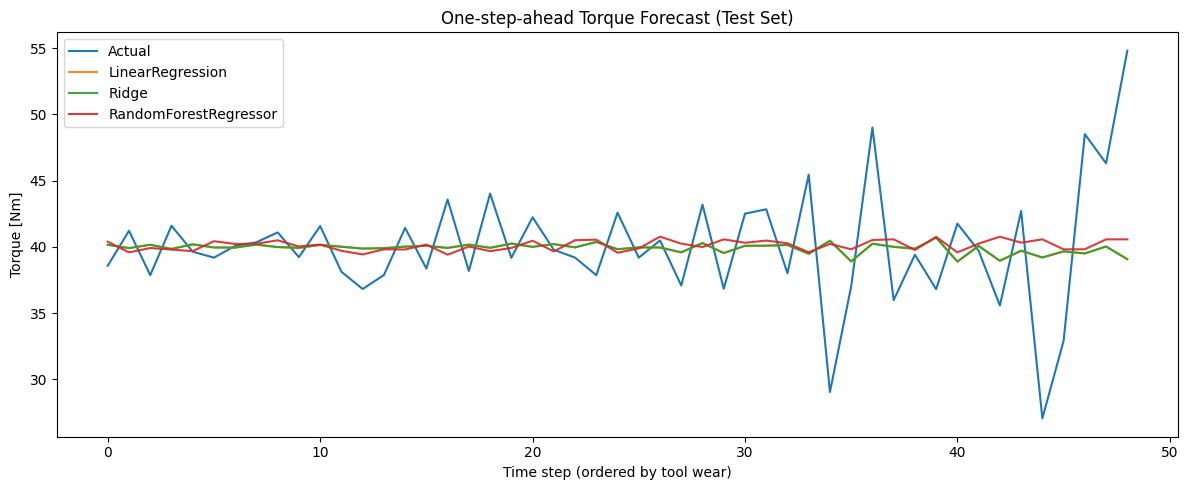

In [12]:
plt.figure(figsize=(12, 5))
plt.plot(y_test.reset_index(drop=True).values, label="Actual")
for name, y_pred in preds.items():
    plt.plot(y_pred, label=name, alpha=0.9)
plt.title("One-step-ahead Torque Forecast (Test Set)")
plt.xlabel("Time step (ordered by tool wear)")
plt.ylabel("Torque [Nm]")
plt.legend()
plt.tight_layout()
plt.show()

### 7. Discussion: regression vs. failure classification

- Torque forecasting predicts a continuous sensor value, which may be useful for anomaly detection.
- Predictive maintenance decisions typically require **failure risk** (classification) rather than a raw sensor forecast.
- Even if torque is predicted accurately, mapping that forecast to a failure decision adds an extra step and can amplify errors.

### 8. Save predictions

This exports a small table with actual and predicted values for reporting.

In [13]:
out = pd.DataFrame({
    "Torque_future_actual": y_test.values,
    **{f"Torque_future_pred_{name}": y_pred for name, y_pred in preds.items()}
})

OUTPUT_PATH = "../data/model1B_torque_forecast_predictions.csv"
out.to_csv(OUTPUT_PATH, index=False)
print(f"Saved predictions to: {OUTPUT_PATH}")
out.head()

Saved predictions to: ../data/model1B_torque_forecast_predictions.csv


,Torque_future_actual,Torque_future_pred_LinearRegression,Torque_future_pred_Ridge,Torque_future_pred_RandomForestRegressor
0,38.569565,40.150744,40.149124,40.381197
1,41.208511,39.899440,39.898446,39.578778
2,37.856410,40.151312,40.150230,39.907429
3,41.584444,39.837399,39.837839,39.786314
4,39.628889,40.185983,40.183500,39.674121


### 9. Export Regression Forecast Results for Tableau

In [ ]:
os.makedirs("../outputs", exist_ok=True)

# Validate preds exists
if "preds" not in globals() or not isinstance(preds, dict) or len(preds) == 0:
    raise NameError("preds dict not found (or empty). Run the model training/evaluation cell first.")

# Pick best model (lowest RMSE)
if "results_df" in globals() and hasattr(results_df, "iloc") and "model" in results_df.columns:
    best_name = results_df.iloc[0]["model"]
else:
    rmse_scores = {name: float(np.sqrt(mean_squared_error(y_test, pred))) for name, pred in preds.items()}
    best_name = min(rmse_scores, key=rmse_scores.get)
    print("RMSE by model:", {k: round(v, 4) for k, v in rmse_scores.items()})

if best_name not in preds:
    raise KeyError(f"Best model '{best_name}' not found in preds keys: {list(preds.keys())}")

y_pred = np.asarray(preds[best_name]).ravel()

print(f"Selected for export: {best_name}")

# Use the notebook's time column
time_col = TIME_COL if "TIME_COL" in globals() else "Tool wear [min]"
if time_col not in X_test.columns:
    raise KeyError(f"'{time_col}' not found in X_test columns: {list(X_test.columns)}")

# Build export dataframe
export_df = pd.DataFrame({
    "tool_wear": X_test[time_col].values,
    "torque_actual_next": np.asarray(y_test).ravel(),
    "torque_pred": y_pred,
    "model_selected": best_name
}).sort_values("tool_wear")

export_df["residual"] = export_df["torque_actual_next"] - export_df["torque_pred"]

# Save
export_path = "../outputs/pred_torque_forecast.csv"
export_df.to_csv(export_path, index=False)

print(f"Saved: {export_path} | rows={len(export_df)}")

Selected for export: Ridge
Saved: ../outputs/pred_torque_forecast.csv | rows=49
